# **A Machine Learning Approach  To Detect Covid-19 Fake Tweets**


## 1. Dataset Loading and visualisation


### Required imports

In [1]:
# Used for dataset loading and visualisation
import pandas as pd
import seaborn as seaborn
import matplotlib.pyplot as plt

### Dataset Loading

In [2]:
# Load training dataset into a pandas dataframe
df_train = pd.read_csv('datasets/TrainData.csv' )

# Load validation dataset into a pandas dataframe
df_val = pd.read_csv('datasets/ValData.csv')

# Load testing dataset into a pandas dataframe
df_test = pd.read_csv('datasets/TestData.csv')

In [3]:
# 7 sample rows from the training dataset
df_train.sample(7)

,id,tweet,label
3891,3892,A video has been viewed hundreds of thousands ...,fake
3428,3429,???CDC announces that students may be kept fro...,fake
6471,6472,PARTS PRICE ONLY During the COVID 19 Lockd...,real
14741,14742,Area food pantries facing new challenges as sp...,real
1288,1289,The Bombay High Court in Mumbai City has exten...,fake
16844,16845,Consumer group attack on financial planners is...,fake
5431,5432,"â€œ60 days into the coronavirus crisis, the Wh...",fake


In [4]:
# 7 first rows from the validation dataset
df_val.head(7)

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real
5,6,No one can leave managed isolation for any rea...,real
6,7,#IndiaFightsCorona India has one of the lowest...,real


In [5]:
# 7 sample rows from the testing dataset
df_test.head(7)

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real
5,6,Low #vitaminD was an independent predictor of ...,real
6,7,A common question: why are the cumulative outc...,real


### Statistics

In [6]:
# Training Data checking
shape = df_train.shape
print('There are {0} tweets and {1} columns for each tweet.'.format(shape[0], shape[1]))
print('Is there any null value? ', df_train.isnull().values.any())
print('The distribution of data into classes is:')
df_train['label'].value_counts()

There are 17200 tweets and 3 columns for each tweet.
Is there any null value?  False
The distribution of data into classes is:


real    8989
fake    8211
Name: label, dtype: int64

In [7]:
# Validation Data checking
shape = df_val.shape
print('There are {0} tweets and {1} columns for each tweet.'.format(shape[0], shape[1]))
print('Is there any null value? ', df_val.isnull().values.any())
print('The distribution of data into classes is:')
df_val['label'].value_counts()

There are 8690 tweets and 3 columns for each tweet.
Is there any null value?  False
The distribution of data into classes is:


real    4603
fake    4087
Name: label, dtype: int64

In [8]:
# Testing Data checking
shape = df_test.shape
print('There are {0} tweets and {1} columns for each tweet.'.format(shape[0], shape[1]))
print('Is there any null value? ', df_test.isnull().values.any())
print('The distribution of data into classes is:')
df_test['label'].value_counts()

There are 9134 tweets and 3 columns for each tweet.
Is there any null value?  False
The distribution of data into classes is:


real    4984
fake    4150
Name: label, dtype: int64

### Droping the columns that are not necessary

In [9]:
columns_to_drop = ['id']
df_train = df_train.drop(columns_to_drop, axis = 1)
df_val = df_val.drop(columns_to_drop, axis = 1)
df_test = df_test.drop(columns_to_drop, axis = 1)
df_train.head(2)

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real


### Merging test and val data to use in k-fold cross validation

In [10]:
df_train = pd.concat([df_train, df_val], ignore_index=True)

### Plotting the class-wise distribution of datasets

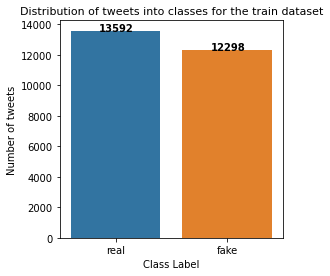

In [11]:
plt.figure(figsize=(4, 4))

ax = seaborn.countplot(
    x = df_train['label'],  
    data = df_train, 
    order = df_train['label'].value_counts().index 
)

ax.set_title('Distribution of tweets into classes for the train dataset', fontsize = 11)
ax.set_xlabel ('Class Label')
ax.set_ylabel ('Number of tweets')

for p, label in zip(ax.patches, df_train['label'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5), weight = 'bold')

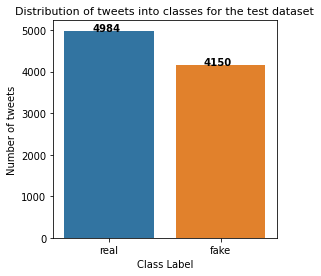

In [12]:
plt.figure(figsize=(4,4))

ax = seaborn.countplot(
    x = df_test['label'], 
    data = df_test, 
    order = df_test['label'].value_counts().index 
    )

ax.set_title('Distribution of tweets into classes for the test dataset', fontsize=11)
ax.set_xlabel ('Class Label')
ax.set_ylabel ('Number of tweets')

for p, label in zip(ax.patches, df_test['label'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5), weight = 'bold')

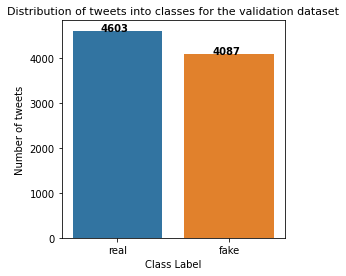

In [13]:
plt.figure(figsize=(4,4))

ax = seaborn.countplot(
    x = df_val['label'], 
    data = df_val, 
    order = df_val['label'].value_counts().index 
    )

ax.set_title('Distribution of tweets into classes for the validation dataset', fontsize=11)
ax.set_xlabel ('Class Label')
ax.set_ylabel ('Number of tweets')

for p, label in zip(ax.patches, df_val['label'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5), weight = 'bold')

## 2. Pre-processing

### Required imports

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
! pip install contractions
import contractions
import string
import re
from collections import Counter
from numpy import array

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.2 MB/s 
     |████████████████████████████████| 106 kB 49.3 MB/s 


### Pre-processing Function

In [15]:
def clean_tweet(tweet):
    # lowercasing the text
    tweet = tweet.lower()
    
    # URL normalization
    url_pattern = '(\w+:\/\/\S+)'
    tweet = re.sub(url_pattern, 'url', tweet)
    
    # Mentions normalization
    mention_pattern = '(\^@[._A-Za-z0-9]+)'
    tweet = re.sub(mention_pattern, '@user', tweet)
    
    # Contractions expansion
    tweet = contractions.fix(tweet)
    
    # split into tokens by white space
    words = tweet.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    
    # remove punctuation from each word
    words = [re_punc.sub('', w) for w in words]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha() or word == 'covid19']
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # filter out short tokens
    words = [word for word in words if len(word) > 2]
        
    return " ".join(words)

In [16]:
nltk.download('omw-1.4')
print(clean_tweet('WHO announces Algeria outside of danger regarding COVID-19'))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


announces algeria outside danger regarding covid19


In [17]:
# Testing the function
sampleTweet = df_train['tweet'][4]
tokens = clean_tweet(sampleTweet)
print('Original tweet: ', sampleTweet,'\n')
print('Pre-processed :', tokens, '\n')

Original tweet:  Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https://t.co/1pYW6cWRaS 

Pre-processed : populous state generate large case count look new case per million today smaller state showing case per million california texas url 



### Applying pre-processing to training and test data

In [18]:
# Preprocess trainingData
df_train['tweet'] = df_train['tweet'].map(lambda x: clean_tweet(x))

# Preprocess validationData
df_test['tweet'] = df_test['tweet'].map(lambda x: clean_tweet(x))

## 3. Feature Extraction

##### 1. BOW Model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(df_train['tweet'])

print("There are {} tweets, each of them represented as a {} dim feature vector"\
      .format(X_train_counts.shape[0], X_train_counts.shape[1]))

There are 25890 tweets, each of them represented as a 36266 dim feature vector


In [20]:
print(X_train_counts.toarray()) #Feature values
# When printed it will seem as if all the values are 0, since it is a very sparse array
# Each row is of size 36266, and only few of those words are encountered in a tweet

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
counts = X_train_counts.toarray()[10]
features = vectorizer.get_feature_names()

print('Preprocessed tweet:', df_train['tweet'][10], '\n')
print('Occurrencies: ')
for i in range(len(features)):
    count = counts[i]
    if(count > 0):
        print('{}: {}'.format(features[i], count))

Preprocessed tweet: take simple daily precaution help prevent spread respiratory illness like covid19 learn protect coronavirus covid19 url url 

Occurrencies: 
coronavirus: 1
covid19: 2
daily: 1
help: 1
illness: 1
learn: 1
like: 1
precaution: 1
prevent: 1
protect: 1
respiratory: 1
simple: 1
spread: 1
take: 1
url: 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### 2. TF-IDF Representation

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf = False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape
print('There are {} tweets and {} is the size of the vocabulary for all the tweets'\
      .format(X_train_tf.shape[0], X_train_tf.shape[1]))

There are 25890 tweets and 36266 is the size of the vocabulary for all the tweets


## 4. Naive Bayes

#### Model Training

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score

pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('clf', MultinomialNB())
    ])

scoring = {'prec_macro': 'precision_macro', 'rec_macro': make_scorer(recall_score, average='macro'), 'f1_macro': 'f1_macro', 'accuracy': 'accuracy'}
scores = cross_validate(pipeline, df_train['tweet'], df_train['label'], cv = 5, scoring = scoring, return_train_score = True)

In [24]:
print('Mean Accuracy:', scores['test_accuracy'].mean())
scores['test_accuracy']

Mean Accuracy: 0.771881035148706


array([0.83043646, 0.76689842, 0.7199691 , 0.80397837, 0.73812283])

In [25]:
print('Mean F1:', scores['test_f1_macro'].mean())
scores['test_f1_macro']

Mean F1: 0.7686077566677338


array([0.82585347, 0.76422867, 0.71677363, 0.80079074, 0.73539228])

In [26]:
print('Mean Precision:', scores['test_prec_macro'].mean())
scores['test_prec_macro']

Mean Precision: 0.7786661416380373


array([0.84986322, 0.76995409, 0.7217824 , 0.81178643, 0.73994456])

In [27]:
print('Mean Recall:', scores['test_rec_macro'].mean())
scores['test_rec_macro']

Mean Recall: 0.7677702624777062


array([0.82436923, 0.76348018, 0.71645534, 0.7996608 , 0.73488577])

In [28]:
fit = pipeline.fit(df_train['tweet'], df_train['label'])

#### Prediction on test data

In [29]:
predictions = pipeline.predict(df_test['tweet'])

#### Confusion Matrix

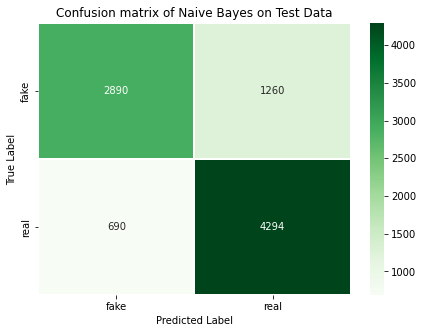

In [30]:
# Plot confusion matrix
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

data = {'true_labels': df_test['label'], 'predicted_labels': predictions}

df = pd.DataFrame(data, columns = ['true_labels', 'predicted_labels'])

confusion_matrix = pd.crosstab(
    df['true_labels'], 
    df['predicted_labels'], 
    rownames = ['True Label'], 
    colnames = ['Predicted Label']
    )

fig, ax = plt.subplots(figsize=(7,5))
sbn.heatmap(confusion_matrix, annot = True, linewidths = 1, fmt = 'd', cmap="Greens")
plt.title("Confusion matrix of Naive Bayes on Test Data")
plt.show()

#### Classification Reports

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

print('_________________Naive Bayes Classifier______________\n')
print(classification_report(df_test['label'], predictions, digits = 4))

_________________Naive Bayes Classifier______________

              precision    recall  f1-score   support

        fake     0.8073    0.6964    0.7477      4150
        real     0.7731    0.8616    0.8150      4984

    accuracy                         0.7865      9134
   macro avg     0.7902    0.7790    0.7813      9134
weighted avg     0.7886    0.7865    0.7844      9134



In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Results
print('Accurracy: ', accuracy_score(df_test['label'], predictions))
print('F1-Score: ', f1_score(df_test['label'], predictions, average='weighted'))
print('Precision Score: ', precision_score(df_test['label'], predictions, average='weighted'))
print('Recall Score: ', recall_score(df_test['label'], predictions, average='weighted'))

Accurracy:  0.7865119334355156
F1-Score:  0.7844145497795664
Precision Score:  0.7886415450210801
Recall Score:  0.7865119334355156
